In [8]:
%matplotlib inline
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm
from collections import Counter

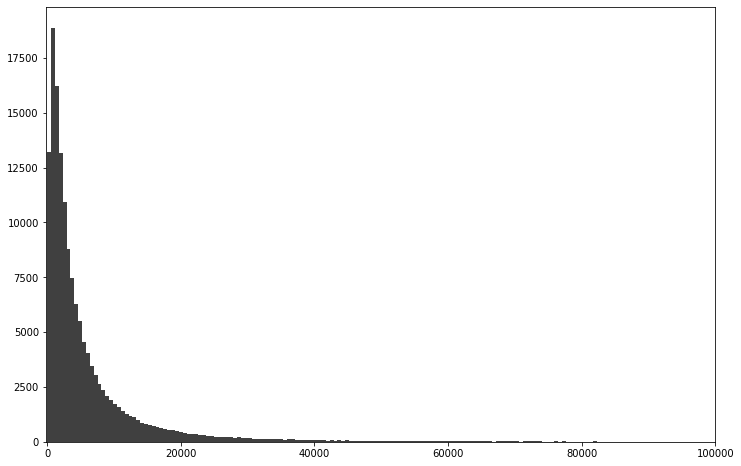

In [9]:
def gene_statis_map(train_dataframe: pd.DataFrame):
    # 计算出price对数正态分布的均值和方差
    log_price = np.log(train_dataframe['price'].values+1)
    log_price_mu = np.mean(log_price)
    log_price_sigma = np.std(log_price)
    # 产生100000个服从于对数正态分布的样本
    samples = [lognorm.rvs(s=log_price_sigma, loc=0, scale=np.exp(log_price_mu)) for _ in range(150000)]
    # 创建一个尺寸为12英寸乘8英寸的画布
    figure = plt.figure(figsize=(12, 8))
    # 在该画布上创建一个子图
    ax = figure.add_subplot(1, 1, 1)
    # 绘制分布直方图
    plt.hist(samples, bins=1000, color='k', alpha=0.75)
    plt.xlim(-200, 100000)
    figure.savefig('../pngs/samples_dist.png', dpi=300)
    ### 从直方图的对比来看，构造出来的随机样本组与真实样本组的分布基本相同
    # 基于这一样本组进行蒙特卡洛试验（5000次），在每一次试验中抽取25个样本，计算出相应的平均值
    #mean_list = [np.mean(random.sample(list(train_dataframe['price'].values), 25)) for i in range(5000)]
    #mean_list_q05 = np.quantile(mean_list, q=0.05)
    #mean_list_q95 = np.quantile(mean_list, q=0.95)
    # 估计出来的均值序列0.05分位数和0.95分位数
    mean_list_q05 = 3768
    mean_list_q95 = 8581
    # 收集每一个地区编码下的交易价格
    region_price_map = {}
    for i_region, i_price in train_dataframe[['regionCode', 'price']].values:
        if i_region not in region_price_map:
            region_price_map[i_region] = []
        region_price_map[i_region].append(i_price)
    region_mean_price_map = {}
    for i_region, price_list in region_price_map.items():
        if len(price_list) <= 15:
            continue
        region_mean_price_map[i_region] = np.mean(price_list)
    region_tag_1_map = {}
    for i_region, mean_price in region_mean_price_map.items():
        if mean_price < mean_list_q05:
            region_tag_1_map[i_region] = -1
        elif mean_price > mean_list_q95:
            region_tag_1_map[i_region] = 1
        else:
            region_tag_1_map[i_region] = 0

    region_bodyType_map = {}
    for i_region, i_bodyType in train_dataframe[['regionCode', 'bodyType']].values:
        if i_region not in region_bodyType_map:
            region_bodyType_map[i_region] = []
        region_bodyType_map[i_region].append(i_bodyType)

    def binomial_prob(n, m, p):
        return math.factorial(n) / (math.factorial(m) * math.factorial(n-m)) * p**m * (1-p)**(n-m)

    region_spe_bodyType_map = {}
    ratio_list = [0.276, 0.235, 0.202, 0.0899, 0.0641, 0.0507, 0.0432, 0.00859]
    for i_region, i_bodyType_list in region_bodyType_map.items():
        if len(i_bodyType_list) < 30:
            region_spe_bodyType_map[i_region] = [0] * 8
            continue
        i_bodyType_counter = Counter(i_bodyType_list)
        i_num = len(i_bodyType_list)
        unnormal_list = []
        for k in range(8):
            k_p = ratio_list[k]
            k_num = i_bodyType_counter[k]
            k_prob = binomial_prob(i_num, k_num, k_p)
            if k_prob < 0.01:
                unnormal_list.append(1)
            else:
                unnormal_list.append(0)
        region_spe_bodyType_map[i_region] = unnormal_list
    return region_tag_1_map, region_spe_bodyType_map


train_data_name = '../data/used_car_train_20200313.csv'
test_data_name = '../data/used_car_testB_20200421.csv'
train_dataframe = pd.read_csv(train_data_name, sep=' ')
test_dataframe = pd.read_csv(test_data_name, sep=' ')
region_tag_1_map, region_tag_2_map = gene_statis_map(train_dataframe)
# 预测目标
whole_target = np.log(train_dataframe['price'].values+1)

In [10]:
def precess_null(dataframe: pd.DataFrame):
    """
    该函数完成对数据集的空值填充

    :param dataframe: pd.DataFrame,
        需要处理的数据集
    :return: pd.DataFrame,
        已经完成空值填充的数据集
    """
    dataframe = dataframe.drop(labels='SaleID', axis=1)
    dataframe = dataframe.drop(labels='name', axis=1)
    # regDate汽车注册日期拆分为年月日三列
    modified_date_list = []
    for i in dataframe['regDate'].values:
        i = str(i)
        i_year = int(i[0:4])
        i_mouth = int(i[4:6])
        i_day = int(i[6:8])
        modified_date_list.append([i_year, i_mouth, i_day])
    modified_date_array = np.array(modified_date_list)
    dataframe['regDate_Year'] = modified_date_array[:, 0]
    dataframe['regDate_Mouth'] = modified_date_array[:, 1]
    dataframe['regDate_Day'] = modified_date_array[:, 2]
    dataframe = dataframe.drop(labels='regDate', axis=1)
    # 车型model有一个数值为空，所以简单的填充车型中最为普遍的0就可以啦。
    dataframe['model'] = dataframe['model'].fillna(value=0)
    # 汽车品牌bodyType中有5%的数值为空，算是空缺比较大的情况，所以凡是空缺的位置填充-1作为特殊标记
    dataframe['bodyType'] = dataframe['bodyType'].fillna(value=-1)
    # 燃料类型fuelType中有8%的数值为空，空缺数量比较大，填充特殊标记-1
    dataframe['fuelType'] = dataframe['fuelType'].fillna(value=-1)
    # 变速箱类型gearbox中有5%的数值为空，填充特殊标记-1
    dataframe['gearbox'] = dataframe['gearbox'].fillna(value=-1)
    # 发动机功率power中有很多异常值，所以进行异常数据压缩和标记工作
    power_values = dataframe['power'].values
    power_values_DB = 10
    power_values_UB = 600
    new_power_seq = []
    new_power_label_seq = []
    for i in power_values:
        if i < power_values_DB:
            new_i = power_values_DB
            new_i_label = -1
        elif i > power_values_UB:
            new_i = power_values_UB
            new_i_label = 1
        else:
            new_i = i
            new_i_label = 0
        new_power_seq.append(new_i)
        new_power_label_seq.append(new_i_label)
    dataframe['power'] = new_power_seq
    dataframe['power_normal_label'] = new_power_label_seq
    # notRepairedDamage字段的替换处理
    notRepairedDamage_replace_map = {'0.0': 0, '1.0': 1, '-': -1}
    dataframe['notRepairedDamage'] = [notRepairedDamage_replace_map[i] for i in dataframe['notRepairedDamage'].values]
    # TODO（张伟健）: 对地区编码进行转换处理
    tag_1_list = []
    tag_2_list = []
    for i_region in dataframe['regionCode'].values:
        tag_1_list.append(region_tag_1_map.get(i_region, 0))
        tag_2_list.append(region_tag_2_map.get(i_region, [0]*8))
    dataframe['regionPriceLevel'] = tag_1_list
    tag_2_array = np.array(tag_2_list)
    for i in range(8):
        dataframe['regionBodyType_%d' % i] = tag_2_array[:, i]
    dataframe = dataframe.drop(labels='regionCode', axis=1)
    # 删除offerType列，该列都是一样的数值，没有任何意义
    dataframe = dataframe.drop(labels='offerType', axis=1)
    # 将creatDate列转换为年月日三列
    modified_date_list = []
    for i in dataframe['creatDate'].values:
        i = str(i)
        i_year = int(i[0:4])
        i_mouth = int(i[4:6])
        i_day = int(i[6:8])
        modified_date_list.append([i_year, i_mouth, i_day])
    modified_date_array = np.array(modified_date_list)
    dataframe['creatDate_Year'] = modified_date_array[:, 0]
    dataframe['creatDate_Mouth'] = modified_date_array[:, 1]
    dataframe['creatDate_Day'] = modified_date_array[:, 2]
    dataframe = dataframe.drop(labels='creatDate', axis=1)
    return dataframe

# 对数据进行空值填充和异常值处理
train_dataframe = precess_null(train_dataframe)
test_dataframe = precess_null(test_dataframe)